### 1. Importação de bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

import warnings
warnings.filterwarnings('ignore')

### 2. Leitura e preparação de dados:

In [2]:
df = pd.read_excel("base_geral.xlsx")

df['ano'] = df['sem_ano'].map(lambda x: x[:4])

df['ano'] = df['ano'].astype(int)

df = df.set_index("sem_ano")

#df = df[df['ano'] >= 2024]

df = df.drop(columns= ["Price_sem_brent", "Price_sem_euro", "ano"], axis = 1)

df = df.rename(columns= {'Price_sem_brent_ajus': 'Price_sem_brent'})

display(df)

,Price_sem_gasoline,Price_sem_dolar,Price_sem_brent
sem_ano,,,
2020-01,4.258600,4.037667,272.239675
2020-02,4.248167,4.076720,271.485092
2020-03,4.272609,4.160520,268.070625
2020-04,4.241917,4.187600,264.430190
2020-05,4.207542,4.231680,249.745290
...,...,...,...
2024-48,5.862632,6.089400,433.078128
2024-49,5.861579,6.041900,450.061131
2024-50,5.853684,6.085300,443.861782


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 2020-01 to 2024-52
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price_sem_gasoline  226 non-null    float64
 1   Price_sem_dolar     226 non-null    float64
 2   Price_sem_brent     226 non-null    float64
dtypes: float64(3)
memory usage: 7.1+ KB
None


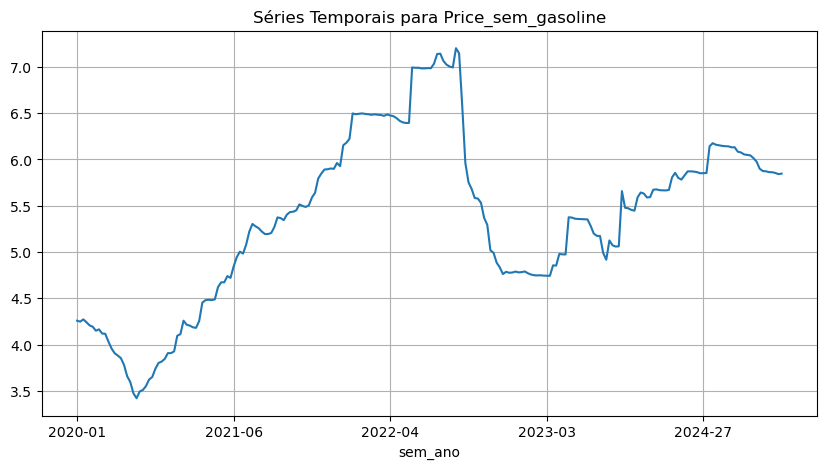

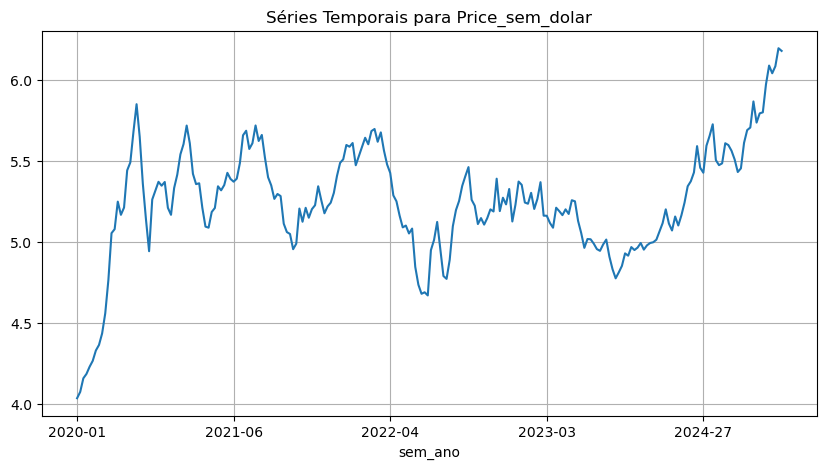

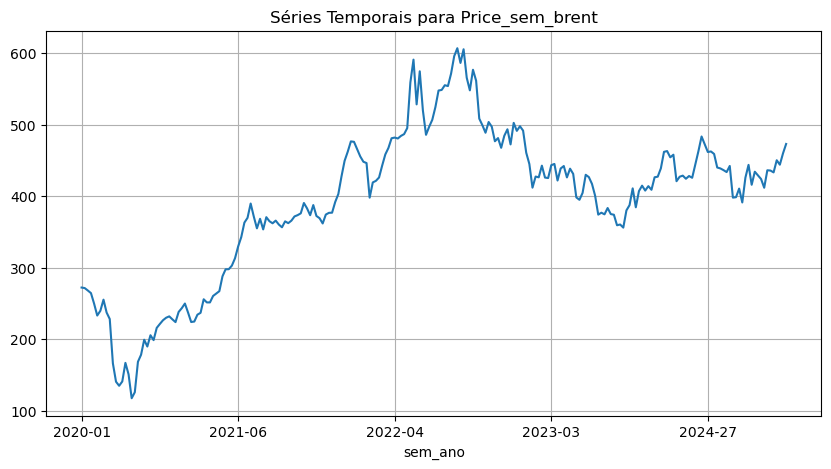

In [4]:
for col in df.columns:
    df[col].plot(title=f'Séries Temporais para {col}', figsize=(10, 5))
    plt.grid(True)
    plt.show()

### 4. Visualização e Correlação

In [5]:
df.describe()

,Price_sem_gasoline,Price_sem_dolar,Price_sem_brent
count,226.000000,226.000000,226.000000
mean,5.365312,5.249872,392.568999
std,0.913969,0.353931,105.723753
min,3.421208,4.037667,117.613640
25%,4.758158,5.081370,359.489954
50%,5.433433,5.243940,416.417078
75%,5.952698,5.471765,460.360396
max,7.200833,6.196400,606.565823


<Axes: >

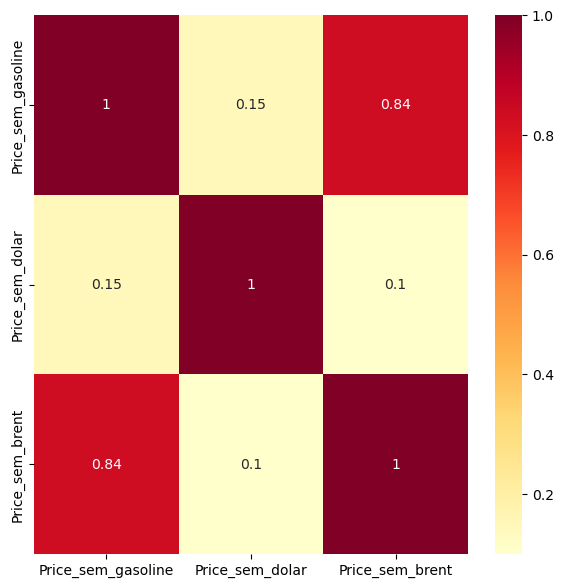

In [6]:
plt.figure(figsize=(7,7))
correlacao = df.corr()
sns.heatmap(correlacao, annot = True,cmap = "YlOrRd")

### 5. Estacionariedade (ADF Test)

In [7]:
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test para {name}')
    print(f'Estatística: {result[0]}')
    print(f'Valor-p: {result[1]}')
    print(f'Valores críticos: {result[4]}')
    if result[1] > 0.05:
        print('Não rejeita H₀ → série tem raiz unitária → não estacionária')
    else:
        print('Rejeita H₀ → série estacionária')
    print('--------------------------------------------------------------------------------------------------')

for col in df.columns:
    adf_test(df[col], col)

ADF Test para Price_sem_gasoline
Estatística: -1.4201500153036337
Valor-p: 0.5725787384207544
Valores críticos: {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}
Não rejeita H₀ → série tem raiz unitária → não estacionária
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_dolar
Estatística: -3.1261949682012458
Valor-p: 0.02467440456778593
Valores críticos: {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}
Rejeita H₀ → série estacionária
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_brent
Estatística: -1.44822514304539
Valor-p: 0.558950696978437
Valores críticos: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
Não rejeita H₀ → série tem raiz unitária → não estacionária
-------------------------------------------------------------------------------

### 6. Cointegração (Johansen)

In [8]:
cj = coint_johansen(df, det_order=0, k_ar_diff=1)
print('Eigenvalues:', cj.eig)
print('Trace statistic:', cj.lr1)
print('Critical values (90%, 95%, 99%):\n', cj.cvt)

print("-------------------------------------------------------------------------------------------------------")

vetor_cointegracao = []

for i, j in zip(cj.lr1, cj.cvt[:, 1]): #para 95%
    if i > j:
        print(round(i,6), "maior que", round(j, 6), "Rejeita a hipótese nula: há cointegração entre as séries")
        vetor_cointegracao.append(1)
    else:
        print(round(i,6), "menor ou igual que", round(j, 6), "Não Rejeita a hipótese nula: não há cointegração entre as séries")
        vetor_cointegracao.append(0)
print("-------------------------------------------------------------------------------------------------------")

if sum(vetor_cointegracao) > 0:
    print(f"Modelo apropriado: VECM – Vector Error Correction Model com r = {sum(vetor_cointegracao)} vetores de cointegração")
else:
    print("Modelo apropriado: VAR - Vector Autoregression")

Eigenvalues: [0.05513894 0.04805489 0.00977058]
Trace statistic: [25.93559934 13.23090334  2.19937292]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
-------------------------------------------------------------------------------------------------------
25.935599 menor ou igual que 29.7961 Não Rejeita a hipótese nula: não há cointegração entre as séries
13.230903 menor ou igual que 15.4943 Não Rejeita a hipótese nula: não há cointegração entre as séries
2.199373 menor ou igual que 3.8415 Não Rejeita a hipótese nula: não há cointegração entre as séries
-------------------------------------------------------------------------------------------------------
Modelo apropriado: VAR - Vector Autoregression


### 7. Diferenciação das séries

ADF Test para Price_sem_gasoline (1ª diferença)
Estatística: -11.527134900366203
Valor-p: 3.91134368417349e-21
Valores críticos: {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}
Rejeita H₀ → série estacionária
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_dolar (1ª diferença)
Estatística: -8.099335544221098
Valor-p: 1.312691830870836e-12
Valores críticos: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
Rejeita H₀ → série estacionária
--------------------------------------------------------------------------------------------------
ADF Test para Price_sem_brent (1ª diferença)
Estatística: -8.124816996805727
Valor-p: 1.1305938053048907e-12
Valores críticos: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
Rejeita H₀ → série estacionária
---------------------------------------------------------------------------------

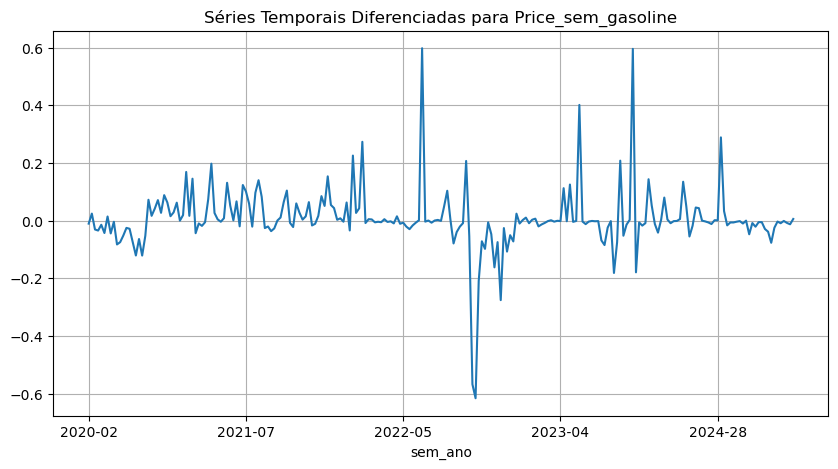

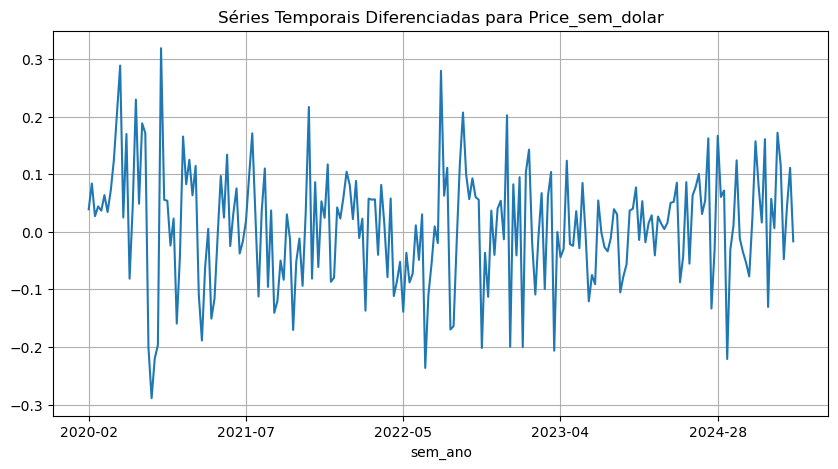

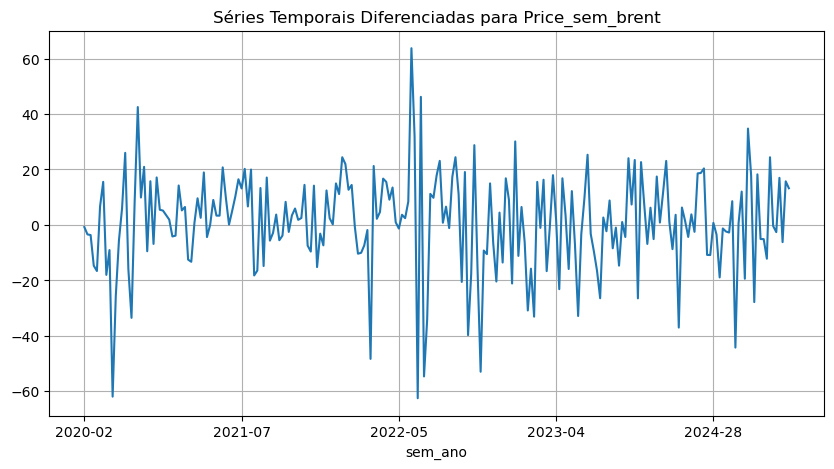

,Price_sem_gasoline,Price_sem_dolar,Price_sem_brent
sem_ano,,,
2020-02,-0.010433,0.039053,-0.754583
2020-03,0.024442,0.083800,-3.414467
2020-04,-0.030692,0.027080,-3.640435
2020-05,-0.034375,0.044080,-14.684899
2020-06,-0.014333,0.036620,-16.619281
...,...,...,...
2024-48,-0.008947,0.116400,-2.592492
2024-49,-0.001053,-0.047500,16.983003
2024-50,-0.007895,0.043400,-6.199349


In [9]:
df_diff = df.diff().dropna()

for col in df_diff.columns:
    adf_test(df_diff[col], f"{col} (1ª diferença)")

for col in df_diff.columns:
    df_diff[col].plot(title=f'Séries Temporais Diferenciadas para {col}', figsize=(10, 5))
    plt.grid(True)
    plt.show()

display(df_diff)

### 8. Seleção de defasagem (Lag)


In [10]:
model = VAR(df_diff)
lag_order = model.select_order(maxlags=10)
print(lag_order.summary())

best_lag = lag_order.aic + 1

print(f"Modelo com {lag_order.aic + 1} defasagens como o ideal (AIC)")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.237     -3.190*     0.03927     -3.218*
1      -3.281*      -3.093    0.03758*      -3.205
2       -3.243      -2.914     0.03905      -3.110
3       -3.246      -2.776     0.03893      -3.056
4       -3.238      -2.626     0.03927      -2.991
5       -3.170      -2.417     0.04205      -2.866
6       -3.125      -2.232     0.04398      -2.764
7       -3.071      -2.036     0.04649      -2.653
8       -3.020      -1.845     0.04894      -2.545
9       -2.997      -1.680     0.05016      -2.465
10      -2.959      -1.501     0.05221      -2.370
--------------------------------------------------
Modelo com 2 defasagens como o ideal (AIC)


### 9. juste do modelo VAR

In [11]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Jun, 2025
Time:                     15:29:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.92853
Nobs:                     223.000    HQIC:                  -3.11985
Log likelihood:          -565.964    FPE:                  0.0388006
AIC:                     -3.24938    Det(Omega_mle):       0.0353647
--------------------------------------------------------------------
Results for equation Price_sem_gasoline
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.004125         0.007009            0.589           0.556
L1.Price_sem_gasoline         0.211815         0.067163            3.154           0.002
L1.Price_sem_do

### 10. ⚠️ Problema de Normalidade nos Resíduos

In [12]:
jb_test = var_model.test_normality()
print(jb_test.summary())
pvalor = jb_test.pvalue
if pvalor > 0.05:
    normalidade = 'H₀ (nula): os resíduos do modelo seguem uma distribuição normal'
else:
    normalidade = 'H₁ (alternativa): os resíduos não seguem distribuição normal'

print(normalidade)

print("Estável?" , var_model.is_stable())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1812.          12.59   0.000  6
----------------------------------------
H₁ (alternativa): os resíduos não seguem distribuição normal
Estável? True


In [14]:
# dataframe com os dados dos resíduos
residuals = pd.DataFrame(var_model.resid, columns=['Price_sem_gasoline','Price_sem_dolar','Price_sem_brent'])
residuals

,Price_sem_gasoline,Price_sem_dolar,Price_sem_brent
sem_ano,,,
2020-04,-0.034624,0.006127,-5.255982
2020-05,-0.020083,0.028873,-14.007951
2020-06,0.009944,0.020134,-17.789499
2020-07,-0.009065,0.048297,5.726519
2020-08,0.028839,0.013528,14.862789
...,...,...,...
2024-48,-0.037811,0.082173,-5.939945
2024-49,0.009898,-0.080452,17.827872
2024-50,-0.017295,0.034953,-4.149666


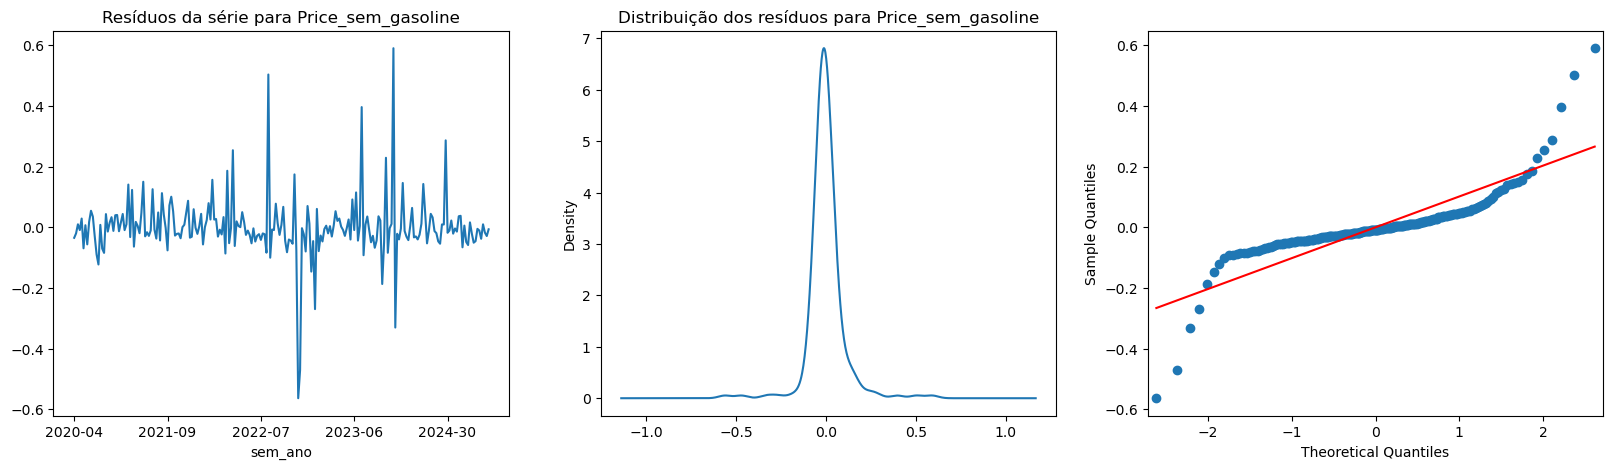

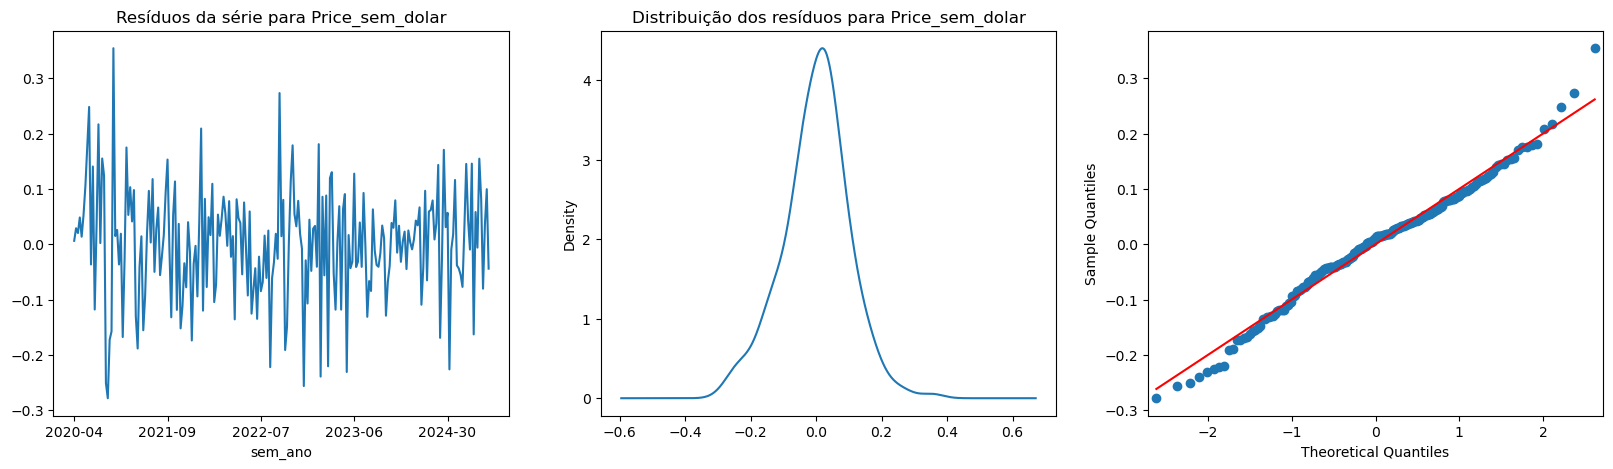

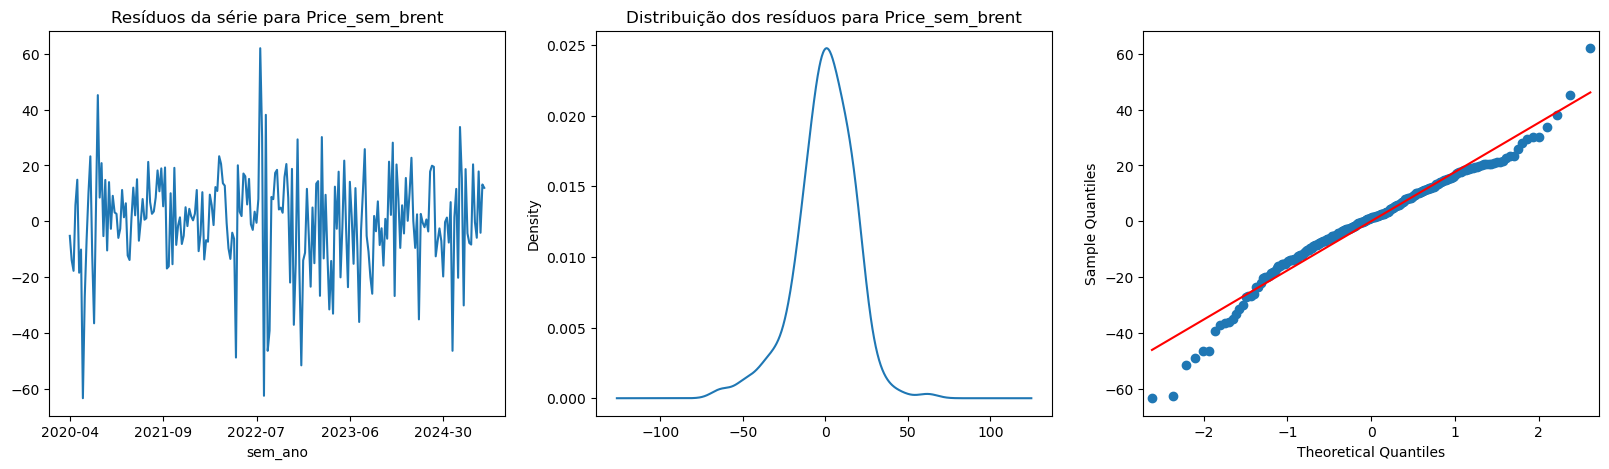

In [17]:
for col in residuals.columns:
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    residuals[col].plot(title=f"Resíduos da série para {col}", ax=ax[0])
    residuals[col].plot(kind='kde', title=f'Distribuição dos resíduos para {col}', ax=ax[1])
    qqplot(residuals[col],line='s', ax=ax[2])
    

In [18]:
for col in residuals.columns:    
    test = jarque_bera(residuals[col])
    print(f'Para a série {col}')
    print('Estatística Jarque-Bera :', test[0])
    print('P-valor :', test[1])
    print('Assimetria :', test[2])
    print('Curtose :',test[3])    
    if test[1] > 0.05:
        normalidade = 'H₀ (nula): os resíduos do modelo seguem uma distribuição normal'
    else:
        normalidade = 'H₁ (alternativa): os resíduos não seguem distribuição normal'
    print(normalidade)
    print(50*"-")

Para a série Price_sem_gasoline
Estatística Jarque-Bera : 1763.5640672997533
P-valor : 0.0
Assimetria : 0.5371736769323737
Curtose : 16.73486056979602
H₁ (alternativa): os resíduos não seguem distribuição normal
--------------------------------------------------
Para a série Price_sem_dolar
Estatística Jarque-Bera : 4.5312664065246455
P-valor : 0.1037643098349437
Assimetria : -0.09609696496347357
Curtose : 3.671365340525439
H₀ (nula): os resíduos do modelo seguem uma distribuição normal
--------------------------------------------------
Para a série Price_sem_brent
Estatística Jarque-Bera : 39.435096410217405
P-valor : 2.733868480090793e-09
Assimetria : -0.5765562526232529
Curtose : 4.7071811523004135
H₁ (alternativa): os resíduos não seguem distribuição normal
--------------------------------------------------


### 11. Autocorrelação dos resíduos: Ljung-Box e Portmanteau → sem evidência de autocorrelação

In [19]:
resid = var_model.resid

for col in resid.columns:
    resultado = acorr_ljungbox(resid[col], lags=[10], return_df=True)
    pvalor = resultado['lb_pvalue'].iloc[0]
    if pvalor > 0.05:
        autocorrelacao = 'H₀ (nula): os resíduos são não autocorrelacionados (comportamento de ruído branco)'
    else:
        autocorrelacao = 'H₁ (alternativa): os resíduos são autocorrelacionados'

    print(f"Ljung-Box para {col}: p-valor = {pvalor:.4f} ⇒ {autocorrelacao}")

Ljung-Box para Price_sem_gasoline: p-valor = 0.8751 ⇒ H₀ (nula): os resíduos são não autocorrelacionados (comportamento de ruído branco)
Ljung-Box para Price_sem_dolar: p-valor = 0.4405 ⇒ H₀ (nula): os resíduos são não autocorrelacionados (comportamento de ruído branco)
Ljung-Box para Price_sem_brent: p-valor = 0.2992 ⇒ H₀ (nula): os resíduos são não autocorrelacionados (comportamento de ruído branco)


In [20]:
white_test = var_model.test_whiteness(nlags=10, adjusted=True)
print(white_test.summary())
print(50*"*")
pvalor = white_test.pvalue

if pvalor > 0.05:
    autocorrelacao = 'H₀ (nula): os resíduos são não autocorrelacionados (comportamento de ruído branco)'
else:
    autocorrelacao = 'H₁ (alternativa): os resíduos são autocorrelacionados'

print(f"Adjusted Portmanteau: p-valor = {pvalor:.4f} ⇒ {autocorrelacao}")

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         77.94          92.81   0.296 72
----------------------------------------
**************************************************
Adjusted Portmanteau: p-valor = 0.2956 ⇒ H₀ (nula): os resíduos são não autocorrelacionados (comportamento de ruído branco)


### 12. Testes de Causalidade de Grange


Resumo dos Resultados por Par de Variáveis

✅ 1. Price_sem_brent → Price_sem_gasoline

Todos os lags (1 a 4) mostram p-valores < 0.05, ou seja:

Há forte evidência de causalidade de Granger.

Interpretação: mudanças nos preços do Brent ajudam a prever mudanças no preço da gasolina no curto prazo.

⚠️ 2. Price_sem_dolar → Price_sem_gasoline

Apenas no lag 3 houve rejeição da hipótese nula (p = 0.0449).

Nos demais lags, não há evidência.

Interpretação: existe evidência pontual e fraca de que o dólar causa variações na gasolina, mas não é consistente ao longo de múltiplos defasagens. Pode indicar uma relação esporádica ou transitória.

❌ 3. Price_sem_gasoline → Price_sem_dolar
Todos os p-valores são acima de 0.3.

Sem evidência de causalidade.

❌ 4. Price_sem_brent → Price_sem_dolar
Todos os p-valores bem acima de 0.4–0.9.

Sem evidência de causalidade.

❌ 5. Price_sem_gasoline → Price_sem_brent
Nenhum p-valor significativo.

Gasolina não afeta Brent, o que é coerente, já que Brent é referência global.

❌ 6. Price_sem_dolar → Price_sem_brent
Todos os p-valores elevados.

Sem causalidade detectada.

In [21]:
for col in df_diff.columns:
    for other_col in df.columns:
        if col != other_col:
            print(f"\nTeste Granger: {other_col} causa {col}?")
            resultado = grangercausalitytests(df_diff[[col, other_col]].dropna(), maxlag=4, verbose=False)
            for lag in range(1, 5):
                pvalor = resultado[lag][0]['ssr_chi2test'][1]  # índice [1] é o p-valor
                if pvalor < 0.05:
                    causa_granger = "rejeita H₀ ⇒ a variável causa a outra no sentido de Granger"
                else:
                    causa_granger = "não rejeita H₀ ⇒ sem evidência de causalidade de Granger"
                print(f"Lag {lag} → p-valor: {pvalor:.4f} - {causa_granger}")


Teste Granger: Price_sem_dolar causa Price_sem_gasoline?
Lag 1 → p-valor: 0.7233 - não rejeita H₀ ⇒ sem evidência de causalidade de Granger
Lag 2 → p-valor: 0.6044 - não rejeita H₀ ⇒ sem evidência de causalidade de Granger
Lag 3 → p-valor: 0.0449 - rejeita H₀ ⇒ a variável causa a outra no sentido de Granger
Lag 4 → p-valor: 0.0936 - não rejeita H₀ ⇒ sem evidência de causalidade de Granger

Teste Granger: Price_sem_brent causa Price_sem_gasoline?
Lag 1 → p-valor: 0.0070 - rejeita H₀ ⇒ a variável causa a outra no sentido de Granger
Lag 2 → p-valor: 0.0017 - rejeita H₀ ⇒ a variável causa a outra no sentido de Granger
Lag 3 → p-valor: 0.0027 - rejeita H₀ ⇒ a variável causa a outra no sentido de Granger
Lag 4 → p-valor: 0.0056 - rejeita H₀ ⇒ a variável causa a outra no sentido de Granger

Teste Granger: Price_sem_gasoline causa Price_sem_dolar?
Lag 1 → p-valor: 0.5014 - não rejeita H₀ ⇒ sem evidência de causalidade de Granger
Lag 2 → p-valor: 0.6263 - não rejeita H₀ ⇒ sem evidência de caus

In [22]:
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    milho = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in milho.columns:
        for r in milho.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            milho.loc[r, c] = min_p_value
    milho.columns = [var + '_x' for var in variables]
    milho.index = [var + '_y' for var in variables]
    return milho

grangers_causation_matrix(df_diff, variables = df_diff.columns)

,Price_sem_gasoline_x,Price_sem_dolar_x,Price_sem_brent_x
Price_sem_gasoline_y,1.0000,0.0449,0.0017
Price_sem_dolar_y,0.2425,1.0000,0.4651
Price_sem_brent_y,0.1529,0.1838,1.0000


### 13. Análise da Função Resposta ao Impulso (Impulse Response Function – IRF)

 Conclusões Gerais

✅ Price_sem_brent afeta Price_sem_gasoline: pequena mas significativa resposta positiva, alinhada com os testes de Granger.

⚠️ Price_sem_dolar tem impacto fraco ou insignificante sobre as demais variáveis.

❌ Gasolina não causa dólar ou Brent: confirmado visualmente.

🔄 Autoregressividade presente em todas as variáveis, especialmente gasolina e dólar.

🧠 Implicações para o Modelo

Brent deve ser mantido como variável explicativa central da gasolina.

A utilização do dólar como preditor pode ser secundária ou descartada, a depender do objetivo.

A modelagem VAR está coerente com a estrutura de relações entre variáveis.

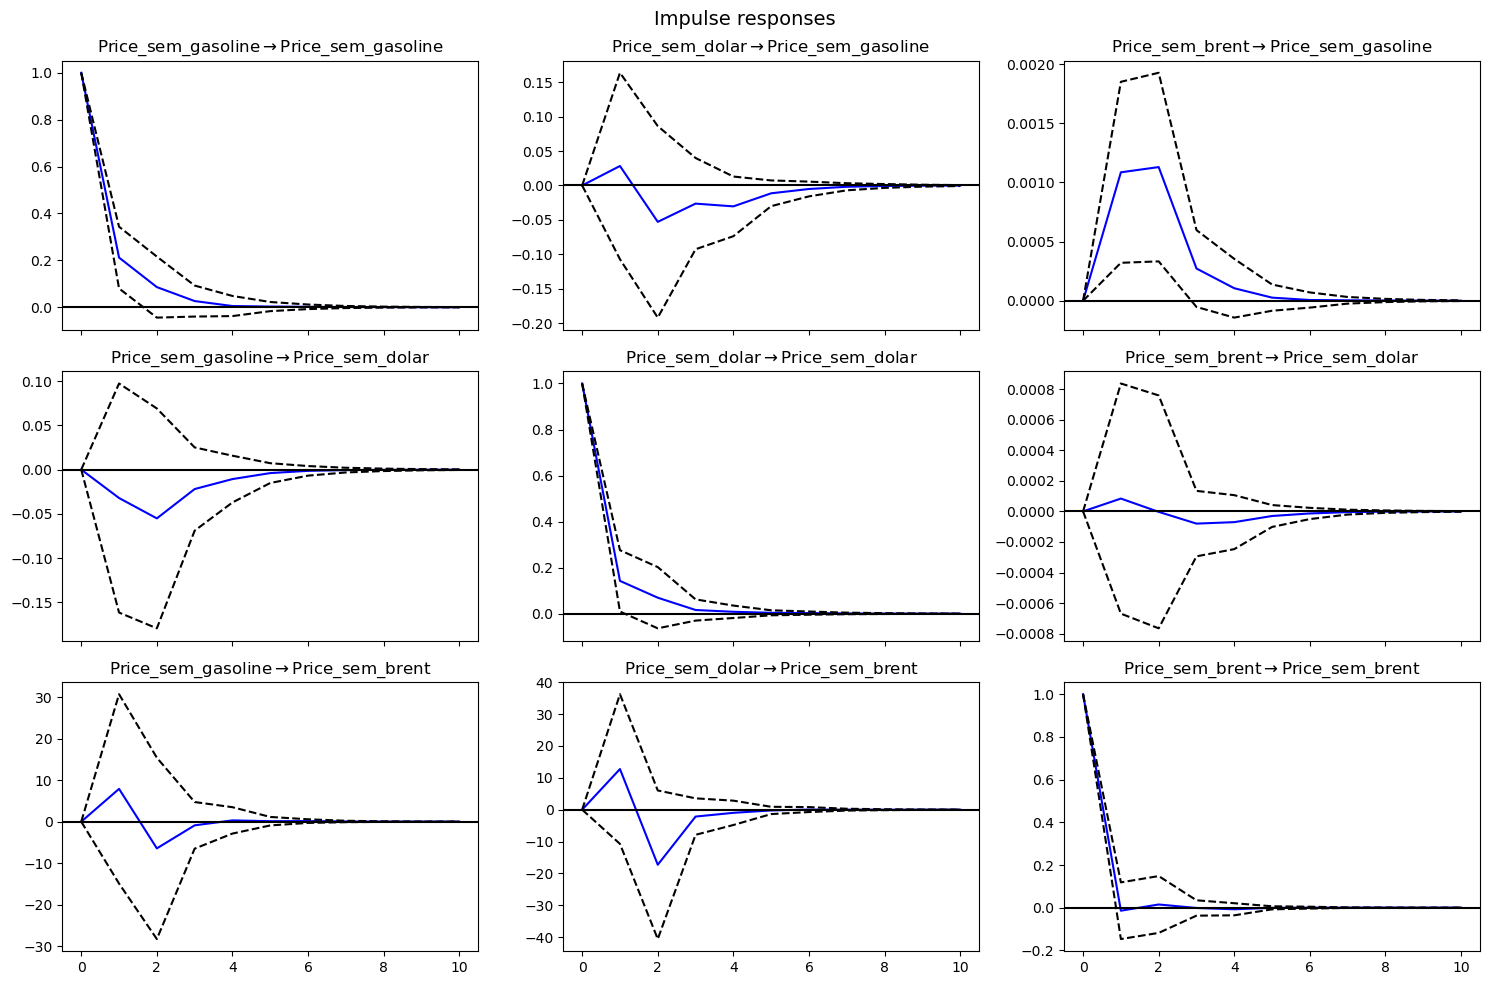

In [20]:
irf = var_model.irf(10)
irf.plot(orth=False, figsize=(15, 10))
plt.tight_layout()
plt.show()

FEVD for Price_sem_gasoline
     Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
0              1.000000         0.000000         0.000000
1              0.966334         0.000926         0.032740
2              0.931873         0.002908         0.065219
3              0.929581         0.003445         0.066974
4              0.928600         0.004204         0.067196
5              0.928483         0.004311         0.067205
6              0.928462         0.004333         0.067204
7              0.928459         0.004336         0.067205
8              0.928459         0.004337         0.067205
9              0.928459         0.004337         0.067205

FEVD for Price_sem_dolar
     Price_sem_gasoline  Price_sem_dolar  Price_sem_brent
0              0.003513         0.996487         0.000000
1              0.005061         0.994726         0.000214
2              0.008536         0.991252         0.000212
3              0.009071         0.990525         0.000404
4              0.0

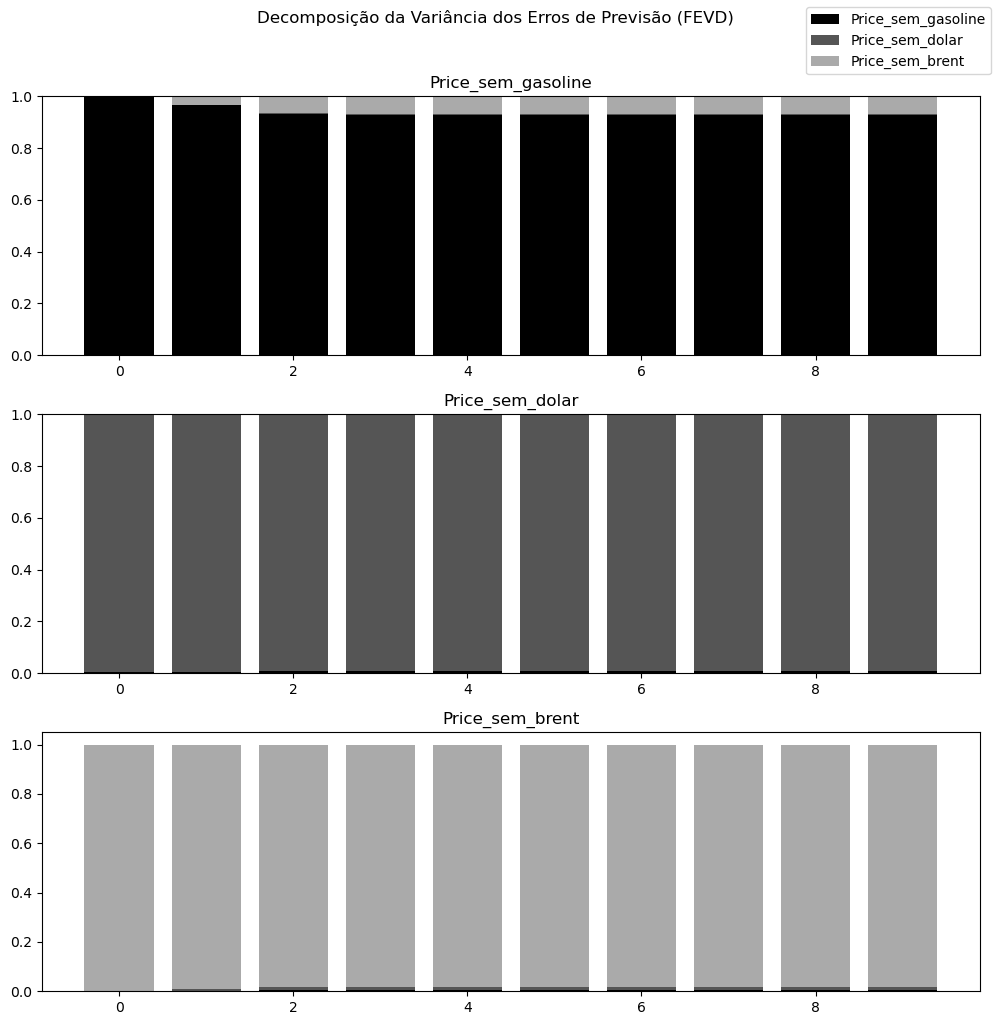

In [21]:
# Horizonte de previsão de 10 períodos
fevd = var_model.fevd(10)

# Mostrar os resultados para y1 e y2
fevd.summary()

fevd.plot()
plt.suptitle("Decomposição da Variância dos Erros de Previsão (FEVD)", y=1.02)
plt.tight_layout()
plt.show()

### 14. Previsão Price_sem_gasoline

In [23]:
steps = 20
last_obs = df_diff.values[-var_model.k_ar:]
forecast_diff = var_model.forecast(y=last_obs, steps=steps)

# Cria DataFrame com as previsões das diferenças
forecast_df = pd.DataFrame(forecast_diff, columns=df_diff.columns)

# Último valor conhecido da série original (antes da diferença)
last_value = df['Price_sem_gasoline'].iloc[-1]

# Reconstruir a série no nível (somando cumulativamente as diferenças)
forecast_level = forecast_df['Price_sem_gasoline'].cumsum() + last_value

display(forecast_level)

0     5.871494
1     5.893303
2     5.902758
3     5.911641
4     5.919223
5     5.926642
6     5.934019
7     5.941368
8     5.948699
9     5.956022
10    5.963339
11    5.970654
12    5.977968
13    5.985281
14    5.992594
15    5.999908
16    6.007221
17    6.014534
18    6.021847
19    6.029160
Name: Price_sem_gasoline, dtype: float64

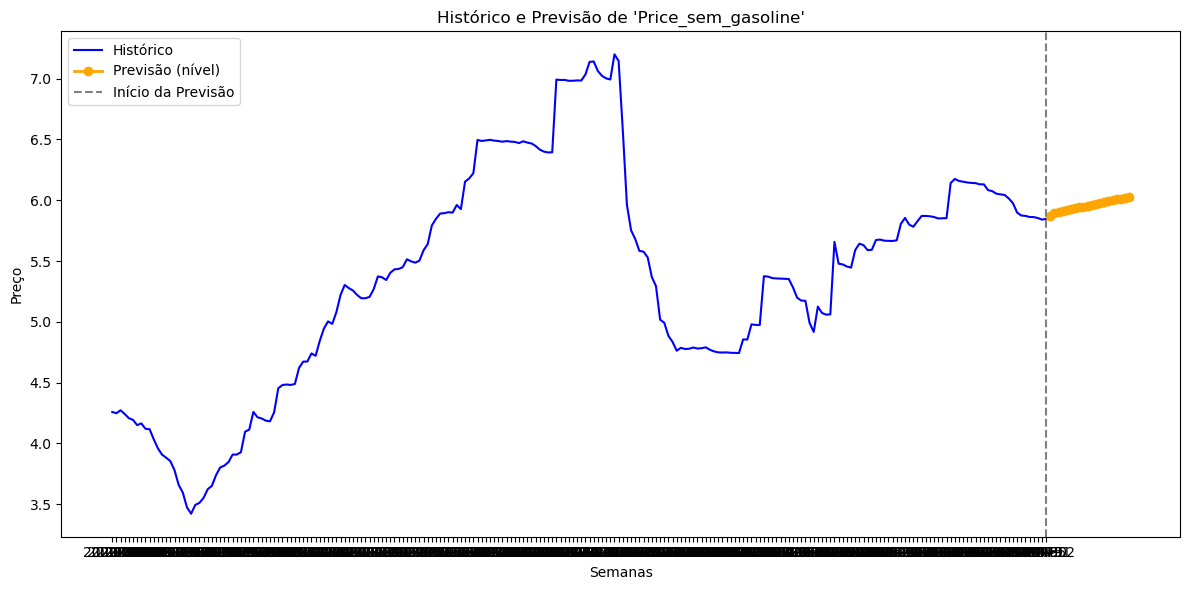

In [24]:
# Recriando o gráfico com base em uma série histórica já existente em df['Price_sem_gasoline']
# e incluindo a previsão (forecast_level) no mesmo gráfico com destaque

# Índices para o eixo x
historical_index = df.index
forecast_index = np.arange(len(df), len(df) + len(forecast_level))

# Concatenando os dados previstos com os dados históricos
plt.figure(figsize=(12, 6))
plt.plot(historical_index, df['Price_sem_gasoline'], label='Histórico', color='blue')
plt.plot(forecast_index, forecast_level, label='Previsão (nível)', color='orange', marker='o', linewidth=2)
plt.axvline(x=historical_index[-1], color='gray', linestyle='--', label='Início da Previsão')

# Estilizando o gráfico
plt.title("Histórico e Previsão de 'Price_sem_gasoline'")
plt.xlabel("Semanas")
plt.ylabel("Preço")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()